In [2]:
#import the libraries
import numpy as np 
import pandas as pd

In [3]:
#Loading the data
df_stores = pd.read_csv(r'C:\Movies and series\important\Projects\Inventory\walmart-recruiting-store-sales-forecasting\stores.csv')
df_features = pd.read_csv(r'C:\Movies and series\important\Projects\Inventory\walmart-recruiting-store-sales-forecasting\features.csv\features.csv')
df_train = pd.read_csv(r'C:\Movies and series\important\Projects\Inventory\walmart-recruiting-store-sales-forecasting\train.csv\train.csv')

In [4]:
df_stores.shape, df_features.shape, df_train.shape

((45, 3), (8190, 12), (421570, 5))

In [5]:
# Step 1: Merge train with features (both have Store + Date)
df_merged = df_train.merge(df_features, on=['Store', 'Date'], how='left')

# Step 2: Merge result with stores (only on Store)
df_full = df_merged.merge(df_stores, on='Store', how='left')


In [6]:
print(df_train.columns)
print(df_features.columns)
print(df_stores.columns)
print(df_merged.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
Index(['Store', 'Type', 'Size'], dtype='object')
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y'],
      dtype='object')


In [7]:
df_full = df_full.drop(columns=['IsHoliday_x'])
df_full = df_full.rename(columns={'IsHoliday_y': 'IsHoliday'})


In [8]:
df_full.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
dtype: int64

In [9]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df_full[markdown_cols] = df_full[markdown_cols].fillna(0)


In [10]:
df_full = df_full.sort_values(by=['Store', 'Dept', 'Date'])


In [11]:
df_full['Lag1'] = df_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df_full['Lag2'] = df_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)

In [13]:
df_full['RollingMean4'] = (
    df_full
    .groupby(['Store', 'Dept'])['Weekly_Sales']
    .shift(1)
    .rolling(window=4)
    .mean()
)
df_full[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Lag1', 'Lag2', 'RollingMean4']].head(10)



,Store,Dept,Date,Weekly_Sales,Lag1,Lag2,RollingMean4
0,1,1,2010-02-05,24924.50,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,24924.50,NaN,NaN
2,1,1,2010-02-19,41595.55,46039.49,24924.50,NaN
3,1,1,2010-02-26,19403.54,41595.55,46039.49,NaN
4,1,1,2010-03-05,21827.90,19403.54,41595.55,32990.7700
5,1,1,2010-03-12,21043.39,21827.90,19403.54,32216.6200
6,1,1,2010-03-19,22136.64,21043.39,21827.90,25967.5950
7,1,1,2010-03-26,26229.21,22136.64,21043.39,21102.8675
8,1,1,2010-04-02,57258.43,26229.21,22136.64,22809.2850
9,1,1,2010-04-09,42960.91,57258.43,26229.21,31666.9175


In [14]:
df_full['Date'] = pd.to_datetime(df_full['Date'])
df_full['WeekOfYear'] = df_full['Date'].dt.isocalendar().week
df_full['Month'] = df_full['Date'].dt.month
df_full['Year'] = df_full['Date'].dt.year
df_full[['Date', 'WeekOfYear', 'Month', 'Year']].head()


,Date,WeekOfYear,Month,Year
0,2010-02-05,5,2,2010
1,2010-02-12,6,2,2010
2,2010-02-19,7,2,2010
3,2010-02-26,8,2,2010
4,2010-03-05,9,3,2010


In [15]:
df_full.to_csv('walmart_sales_features.csv', index=False)


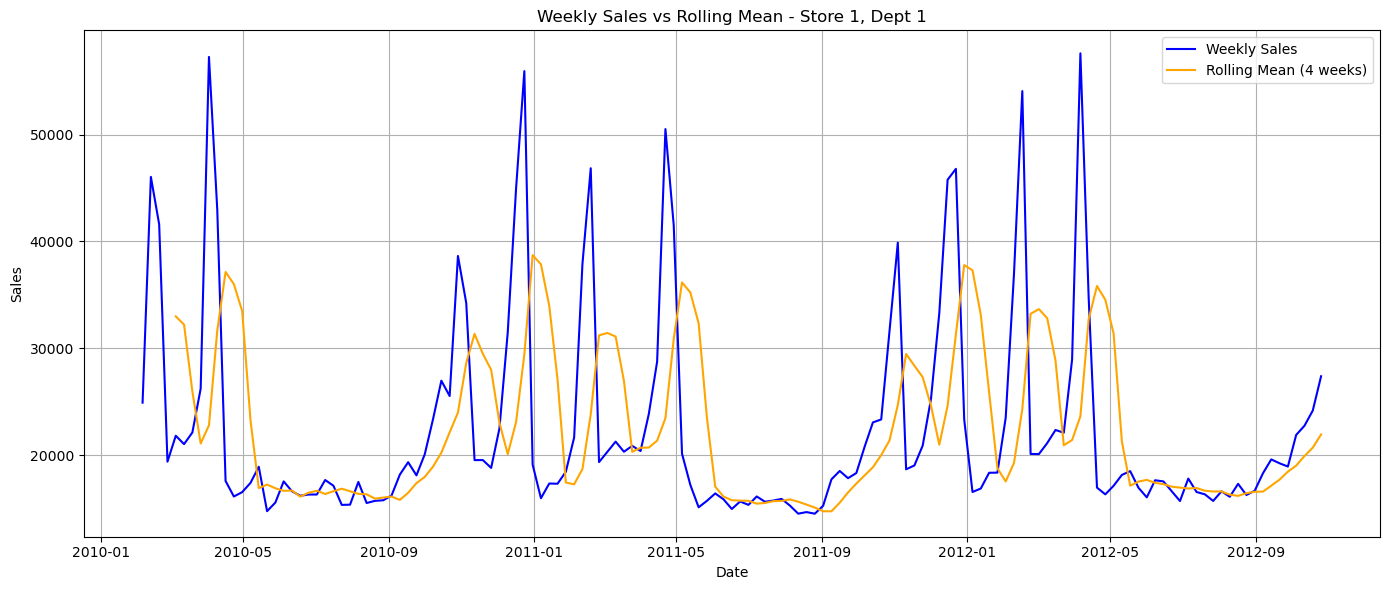

In [17]:
sample_df = df_full[(df_full['Store'] == 1) & (df_full['Dept'] == 1)]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(sample_df['Date'], sample_df['Weekly_Sales'], label='Weekly Sales', color='blue')
plt.plot(sample_df['Date'], sample_df['RollingMean4'], label='Rolling Mean (4 weeks)', color='orange')
plt.title('Weekly Sales vs Rolling Mean - Store 1, Dept 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
prophet_df = sample_df.rename(columns={
    'Date': 'ds',
    'Weekly_Sales': 'y'
})[['ds', 'y']]


In [19]:
pip install prophet


   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----------- ---------------------------- 3.7/13.3 MB 19.8 MB/s eta 0:00:01
   ------------------- -------------------- 6.6/13.3 MB 15.5 MB/s eta 0:00:01
   -------------------------------- ------- 10.7/13.3 MB 17.2 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 16.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   --------------------------------------- 954.8/954.8 kB 14.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from prophet import Prophet
model = Prophet()
model.fit(prophet_df)

14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)


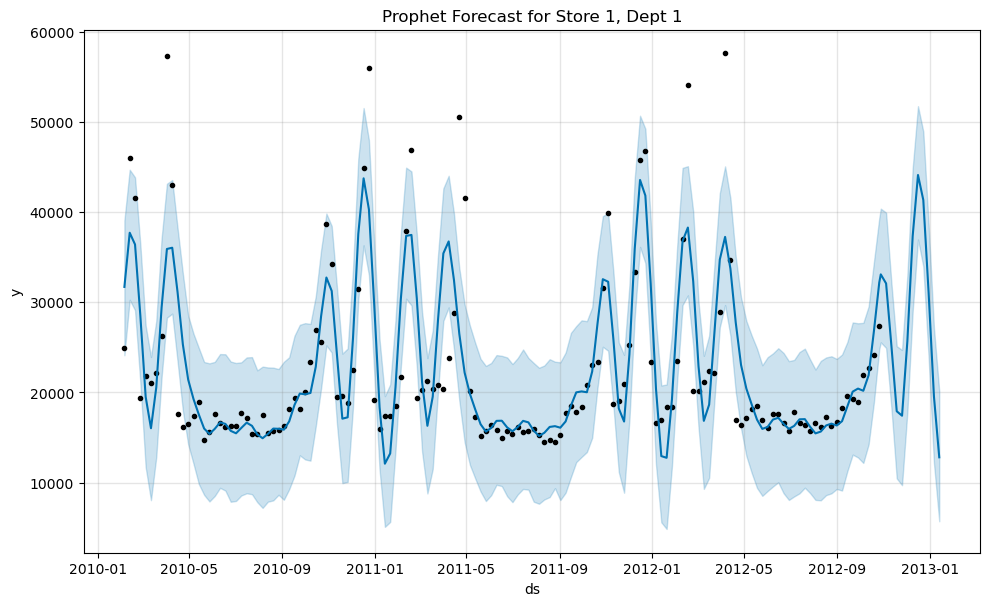

In [23]:
model.plot(forecast)
plt.title('Prophet Forecast for Store 1, Dept 1')
plt.show()

In [24]:
train=prophet_df[:-12]
test=prophet_df[-12:]
model = Prophet()
model.fit(train)


14:28:25 - cmdstanpy - INFO - Chain [1] start processing
14:28:25 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
y_pred = forecast['yhat'][-12:]
y_true = test['y']
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'MAE: {mae}',round(mae, 2))
print(f'RMSE: {rmse}',round(rmse, 2))  

ModuleNotFoundError: No module named 'sklearn.modelselection'